# Library

In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opendatasets

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Library to dataset
import opendatasets as od
import os
import zipfile
import numpy as np

# Surpress Warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# library visualization
import matplotlib.pyplot as plt

# Library Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet121
# Others
import shutil
import random

# Load dataset

In [2]:
# Load dataset
print("==========================Training Data====================")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Bell_pepper/train",
    label_mode="categorical",
    class_names= ['Pepper bell Bacterial spot', 'Pepper bell healthy'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)
print("==========================Validation Data====================")
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Bell_pepper/test",
    label_mode="categorical",
    class_names= ['Pepper bell Bacterial spot', 'Pepper bell healthy'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=False,
    seed=123
)

==========================Training Data====================
Found 4033 files belonging to 2 classes.
==========================Validation Data====================
Found 962 files belonging to 2 classes.


In [3]:
# All images will be rescaled by 1./256. and Augmented
train_datagen = ImageDataGenerator(rescale = 1.0/256.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen  = ImageDataGenerator(rescale = 1.0/256.)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory("Dataset/Bell_pepper/train",
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory("Dataset/Bell_pepper/test",
                                                         batch_size=20,
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))

Found 4033 images belonging to 2 classes.
Found 962 images belonging to 2 classes.


# List Resource

In [6]:
# Check GPU
!nvidia-smi

Sat May 27 15:28:47 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 532.03                 Driver Version: 532.03       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 L...  WDDM | 00000000:01:00.0  On |                  N/A |
| N/A   54C    P0               30W /  N/A|   5872MiB /  6144MiB |      8%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
# Lis physical devices
devices = tf.config.experimental.list_physical_devices("GPU")
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
# Define the GPU strategy
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# Modelling With Augmentation

## DIY Model 1

In [9]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="BellPaper_DIY_model1_Based_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [10]:
# Define DIY Model
DIY_model = tf.keras.models.Sequential([
    # Convolutional Layers with 32 filters
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),
    # Convolutional Layers with 64 filters
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),  
    # Convolutional Layers with 128 filters
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),  
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(2, activation='softmax') 
  ])


# Compile Model
DIY_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
DIY_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [11]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_DIY_model = DIY_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
202/202 [==============================] - ETA: 0s - loss: 0.4727 - accuracy: 0.7984
Epoch 1: val_accuracy improved from -inf to 0.94387, saving model to BellPaper_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: BellPaper_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_DIY_model1_Based_Augmented\assets


202/202 [==============================] - 45s 196ms/step - loss: 0.4727 - accuracy: 0.7984 - val_loss: 0.1295 - val_accuracy: 0.9439 - lr: 0.0010
Epoch 2/100
202/202 [==============================] - ETA: 0s - loss: 0.2678 - accuracy: 0.9110
Epoch 2: val_accuracy did not improve from 0.94387
202/202 [==============================] - 35s 175ms/step - loss: 0.2678 - accuracy: 0.9110 - val_loss: 0.2403 - val_accuracy: 0.9106 - lr: 0.0010
Epoch 3/100
202/202 [==============================] - ETA: 0s - loss: 0.2128 - accuracy: 0.9286
Epoch 3: val_accuracy improved from 0.94387 to 0.96154, saving model to BellPaper_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: BellPaper_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_DIY_model1_Based_Augmented\assets


202/202 [==============================] - 35s 174ms/step - loss: 0.2128 - accuracy: 0.9286 - val_loss: 0.1236 - val_accuracy: 0.9615 - lr: 0.0010
Epoch 4/100
202/202 [==============================] - ETA: 0s - loss: 0.1590 - accuracy: 0.9531
Epoch 4: val_accuracy improved from 0.96154 to 0.97193, saving model to BellPaper_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: BellPaper_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_DIY_model1_Based_Augmented\assets


202/202 [==============================] - 34s 169ms/step - loss: 0.1590 - accuracy: 0.9531 - val_loss: 0.0809 - val_accuracy: 0.9719 - lr: 0.0010
Epoch 5/100
202/202 [==============================] - ETA: 0s - loss: 0.0940 - accuracy: 0.9695
Epoch 5: val_accuracy improved from 0.97193 to 0.98441, saving model to BellPaper_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: BellPaper_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_DIY_model1_Based_Augmented\assets


202/202 [==============================] - 32s 156ms/step - loss: 0.0940 - accuracy: 0.9695 - val_loss: 0.0411 - val_accuracy: 0.9844 - lr: 0.0010
Epoch 6/100
202/202 [==============================] - ETA: 0s - loss: 0.1110 - accuracy: 0.9663
Epoch 6: val_accuracy improved from 0.98441 to 0.98649, saving model to BellPaper_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: BellPaper_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_DIY_model1_Based_Augmented\assets


202/202 [==============================] - 34s 167ms/step - loss: 0.1110 - accuracy: 0.9663 - val_loss: 0.0563 - val_accuracy: 0.9865 - lr: 0.0010
Epoch 7/100
202/202 [==============================] - ETA: 0s - loss: 0.0888 - accuracy: 0.9702
Epoch 7: val_accuracy did not improve from 0.98649
202/202 [==============================] - 31s 154ms/step - loss: 0.0888 - accuracy: 0.9702 - val_loss: 0.2183 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 8/100
202/202 [==============================] - ETA: 0s - loss: 0.0634 - accuracy: 0.9750
Epoch 8: val_accuracy improved from 0.98649 to 0.99480, saving model to BellPaper_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: BellPaper_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_DIY_model1_Based_Augmented\assets


202/202 [==============================] - 33s 164ms/step - loss: 0.0634 - accuracy: 0.9750 - val_loss: 0.0205 - val_accuracy: 0.9948 - lr: 0.0010
Epoch 9/100
202/202 [==============================] - ETA: 0s - loss: 0.0712 - accuracy: 0.9752
Epoch 9: val_accuracy improved from 0.99480 to 0.99792, saving model to BellPaper_DIY_model1_Based_Augmented


INFO:tensorflow:Assets written to: BellPaper_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_DIY_model1_Based_Augmented\assets


202/202 [==============================] - 35s 173ms/step - loss: 0.0712 - accuracy: 0.9752 - val_loss: 0.0165 - val_accuracy: 0.9979 - lr: 0.0010
Epoch 10/100
202/202 [==============================] - ETA: 0s - loss: 0.0771 - accuracy: 0.9752
Epoch 10: val_accuracy did not improve from 0.99792
202/202 [==============================] - 32s 159ms/step - loss: 0.0771 - accuracy: 0.9752 - val_loss: 0.0917 - val_accuracy: 0.9813 - lr: 0.0010
Epoch 11/100
202/202 [==============================] - ETA: 0s - loss: 0.0714 - accuracy: 0.9789
Epoch 11: val_accuracy did not improve from 0.99792
202/202 [==============================] - 33s 161ms/step - loss: 0.0714 - accuracy: 0.9789 - val_loss: 0.0145 - val_accuracy: 0.9958 - lr: 0.0010
Epoch 12/100
202/202 [==============================] - ETA: 0s - loss: 0.0804 - accuracy: 0.9755
Epoch 12: val_accuracy did not improve from 0.99792
202/202 [==============================] - 33s 161ms/step - loss: 0.0804 - accuracy: 0.9755 - val_loss: 0.033

INFO:tensorflow:Assets written to: BellPaper_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_DIY_model1_Based_Augmented\assets


202/202 [==============================] - 37s 183ms/step - loss: 0.0293 - accuracy: 0.9891 - val_loss: 0.0044 - val_accuracy: 0.9990 - lr: 1.0000e-04
Epoch 20/100
202/202 [==============================] - ETA: 0s - loss: 0.0282 - accuracy: 0.9888
Epoch 20: val_accuracy did not improve from 0.99896
202/202 [==============================] - 31s 151ms/step - loss: 0.0282 - accuracy: 0.9888 - val_loss: 0.0079 - val_accuracy: 0.9969 - lr: 1.0000e-04
Epoch 21/100
202/202 [==============================] - ETA: 0s - loss: 0.0238 - accuracy: 0.9918
Epoch 21: val_accuracy did not improve from 0.99896
202/202 [==============================] - 31s 155ms/step - loss: 0.0238 - accuracy: 0.9918 - val_loss: 0.0071 - val_accuracy: 0.9958 - lr: 1.0000e-04
Epoch 22/100
202/202 [==============================] - ETA: 0s - loss: 0.0266 - accuracy: 0.9891
Epoch 22: val_accuracy did not improve from 0.99896
202/202 [==============================] - 30s 150ms/step - loss: 0.0266 - accuracy: 0.9891 - val

INFO:tensorflow:Assets written to: BellPaper_DIY_model1_Based_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_DIY_model1_Based_Augmented\assets


202/202 [==============================] - 37s 181ms/step - loss: 0.0239 - accuracy: 0.9901 - val_loss: 0.0022 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 25/100
202/202 [==============================] - ETA: 0s - loss: 0.0256 - accuracy: 0.9888
Epoch 25: val_accuracy did not improve from 1.00000
202/202 [==============================] - 32s 155ms/step - loss: 0.0256 - accuracy: 0.9888 - val_loss: 0.0124 - val_accuracy: 0.9969 - lr: 1.0000e-04
Epoch 26/100
202/202 [==============================] - ETA: 0s - loss: 0.0226 - accuracy: 0.9898
Epoch 26: val_accuracy did not improve from 1.00000
202/202 [==============================] - 31s 152ms/step - loss: 0.0226 - accuracy: 0.9898 - val_loss: 0.0017 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 27/100
202/202 [==============================] - ETA: 0s - loss: 0.0232 - accuracy: 0.9908
Epoch 27: val_accuracy did not improve from 1.00000
202/202 [==============================] - 31s 156ms/step - loss: 0.0232 - accuracy: 0.9908 - val

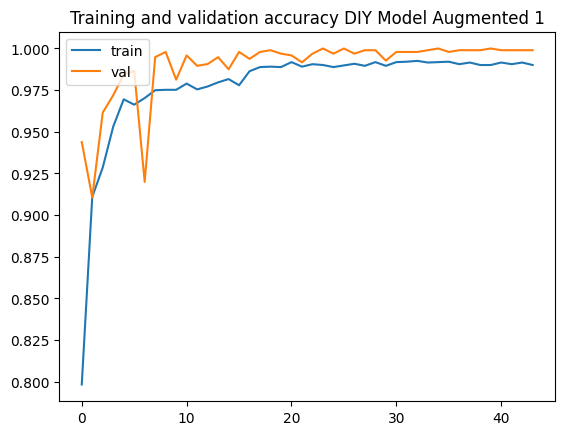

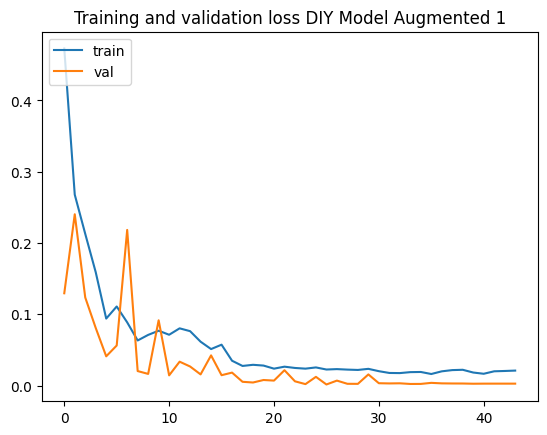

In [12]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_DIY_model.history['accuracy' ]
val_acc  = history_DIY_model.history['val_accuracy' ]
loss     = history_DIY_model.history['loss' ]
val_loss = history_DIY_model.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DIY Model Augmented 1')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DIY Model Augmented 1')
plt.legend(['train', 'val'], loc='upper left')

## DIY Model 2

In [13]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="BellPaper_DIY_model2_Based_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [14]:
# Define DIY Model
DIY_model_2 = tf.keras.models.Sequential([
    # Convolutional Layers with 32 filters
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),
    # Convolutional Layers with 64 filters
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),  
    # Convolutional Layers with 128 filters
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    # MaxPooling Layer
    tf.keras.layers.MaxPooling2D(2,2),  
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 1024 neuron hidden layer
    tf.keras.layers.Dense(1024, activation='relu'),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(2, activation='softmax') 
  ])


# Compile Model
DIY_model_2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
DIY_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 26, 26, 128)     

In [15]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_DIY_model_2 = DIY_model_2.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
202/202 [==============================] - ETA: 0s - loss: 0.5579 - accuracy: 0.7357
Epoch 1: val_accuracy improved from -inf to 0.91892, saving model to BellPaper_DIY_model2_Based_Augmented


INFO:tensorflow:Assets written to: BellPaper_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_DIY_model2_Based_Augmented\assets


202/202 [==============================] - 33s 161ms/step - loss: 0.5579 - accuracy: 0.7357 - val_loss: 0.2187 - val_accuracy: 0.9189 - lr: 0.0010
Epoch 2/100
202/202 [==============================] - ETA: 0s - loss: 0.3432 - accuracy: 0.8862
Epoch 2: val_accuracy did not improve from 0.91892
202/202 [==============================] - 33s 163ms/step - loss: 0.3432 - accuracy: 0.8862 - val_loss: 0.4644 - val_accuracy: 0.7963 - lr: 0.0010
Epoch 3/100
202/202 [==============================] - ETA: 0s - loss: 0.2715 - accuracy: 0.9117
Epoch 3: val_accuracy improved from 0.91892 to 0.96778, saving model to BellPaper_DIY_model2_Based_Augmented


INFO:tensorflow:Assets written to: BellPaper_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_DIY_model2_Based_Augmented\assets


202/202 [==============================] - 38s 189ms/step - loss: 0.2715 - accuracy: 0.9117 - val_loss: 0.1002 - val_accuracy: 0.9678 - lr: 0.0010
Epoch 4/100
202/202 [==============================] - ETA: 0s - loss: 0.1813 - accuracy: 0.9457
Epoch 4: val_accuracy did not improve from 0.96778
202/202 [==============================] - 30s 146ms/step - loss: 0.1813 - accuracy: 0.9457 - val_loss: 0.1024 - val_accuracy: 0.9480 - lr: 0.0010
Epoch 5/100
202/202 [==============================] - ETA: 0s - loss: 0.1508 - accuracy: 0.9494
Epoch 5: val_accuracy did not improve from 0.96778
202/202 [==============================] - 30s 150ms/step - loss: 0.1508 - accuracy: 0.9494 - val_loss: 0.1352 - val_accuracy: 0.9345 - lr: 0.0010
Epoch 6/100
202/202 [==============================] - ETA: 0s - loss: 0.1054 - accuracy: 0.9673
Epoch 6: val_accuracy improved from 0.96778 to 0.97401, saving model to BellPaper_DIY_model2_Based_Augmented


INFO:tensorflow:Assets written to: BellPaper_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_DIY_model2_Based_Augmented\assets


202/202 [==============================] - 36s 179ms/step - loss: 0.1054 - accuracy: 0.9673 - val_loss: 0.0623 - val_accuracy: 0.9740 - lr: 0.0010
Epoch 7/100
202/202 [==============================] - ETA: 0s - loss: 0.0973 - accuracy: 0.9730
Epoch 7: val_accuracy did not improve from 0.97401
202/202 [==============================] - 30s 148ms/step - loss: 0.0973 - accuracy: 0.9730 - val_loss: 0.4530 - val_accuracy: 0.8701 - lr: 0.0010
Epoch 8/100
202/202 [==============================] - ETA: 0s - loss: 0.1136 - accuracy: 0.9631
Epoch 8: val_accuracy improved from 0.97401 to 0.98545, saving model to BellPaper_DIY_model2_Based_Augmented


INFO:tensorflow:Assets written to: BellPaper_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_DIY_model2_Based_Augmented\assets


202/202 [==============================] - 38s 187ms/step - loss: 0.1136 - accuracy: 0.9631 - val_loss: 0.0301 - val_accuracy: 0.9854 - lr: 0.0010
Epoch 9/100
202/202 [==============================] - ETA: 0s - loss: 0.0885 - accuracy: 0.9722
Epoch 9: val_accuracy did not improve from 0.98545
202/202 [==============================] - 30s 147ms/step - loss: 0.0885 - accuracy: 0.9722 - val_loss: 0.0356 - val_accuracy: 0.9844 - lr: 0.0010
Epoch 10/100
202/202 [==============================] - ETA: 0s - loss: 0.0826 - accuracy: 0.9712
Epoch 10: val_accuracy improved from 0.98545 to 0.99480, saving model to BellPaper_DIY_model2_Based_Augmented


INFO:tensorflow:Assets written to: BellPaper_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_DIY_model2_Based_Augmented\assets


202/202 [==============================] - 36s 177ms/step - loss: 0.0826 - accuracy: 0.9712 - val_loss: 0.0199 - val_accuracy: 0.9948 - lr: 0.0010
Epoch 11/100
202/202 [==============================] - ETA: 0s - loss: 0.0874 - accuracy: 0.9740
Epoch 11: val_accuracy did not improve from 0.99480
202/202 [==============================] - 29s 144ms/step - loss: 0.0874 - accuracy: 0.9740 - val_loss: 0.0339 - val_accuracy: 0.9875 - lr: 0.0010
Epoch 12/100
202/202 [==============================] - ETA: 0s - loss: 0.0853 - accuracy: 0.9742
Epoch 12: val_accuracy did not improve from 0.99480
202/202 [==============================] - 28s 140ms/step - loss: 0.0853 - accuracy: 0.9742 - val_loss: 0.0667 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 13/100
202/202 [==============================] - ETA: 0s - loss: 0.1027 - accuracy: 0.9715
Epoch 13: val_accuracy did not improve from 0.99480
202/202 [==============================] - 29s 145ms/step - loss: 0.1027 - accuracy: 0.9715 - val_loss: 0.025

INFO:tensorflow:Assets written to: BellPaper_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_DIY_model2_Based_Augmented\assets


202/202 [==============================] - 36s 177ms/step - loss: 0.0377 - accuracy: 0.9881 - val_loss: 0.0086 - val_accuracy: 0.9969 - lr: 1.0000e-04
Epoch 23/100
202/202 [==============================] - ETA: 0s - loss: 0.0347 - accuracy: 0.9876
Epoch 23: val_accuracy improved from 0.99688 to 0.99792, saving model to BellPaper_DIY_model2_Based_Augmented


INFO:tensorflow:Assets written to: BellPaper_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_DIY_model2_Based_Augmented\assets


202/202 [==============================] - 36s 180ms/step - loss: 0.0347 - accuracy: 0.9876 - val_loss: 0.0081 - val_accuracy: 0.9979 - lr: 1.0000e-04
Epoch 24/100
202/202 [==============================] - ETA: 0s - loss: 0.0335 - accuracy: 0.9871
Epoch 24: val_accuracy did not improve from 0.99792
202/202 [==============================] - 29s 145ms/step - loss: 0.0335 - accuracy: 0.9871 - val_loss: 0.0293 - val_accuracy: 0.9844 - lr: 1.0000e-04
Epoch 25/100
202/202 [==============================] - ETA: 0s - loss: 0.0276 - accuracy: 0.9896
Epoch 25: val_accuracy did not improve from 0.99792
202/202 [==============================] - 30s 149ms/step - loss: 0.0276 - accuracy: 0.9896 - val_loss: 0.0110 - val_accuracy: 0.9948 - lr: 1.0000e-04
Epoch 26/100
202/202 [==============================] - ETA: 0s - loss: 0.0362 - accuracy: 0.9879
Epoch 26: val_accuracy did not improve from 0.99792
202/202 [==============================] - 29s 142ms/step - loss: 0.0362 - accuracy: 0.9879 - val

INFO:tensorflow:Assets written to: BellPaper_DIY_model2_Based_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_DIY_model2_Based_Augmented\assets


202/202 [==============================] - 37s 183ms/step - loss: 0.0302 - accuracy: 0.9893 - val_loss: 0.0036 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 30/100
202/202 [==============================] - ETA: 0s - loss: 0.0286 - accuracy: 0.9913
Epoch 30: val_accuracy did not improve from 1.00000
202/202 [==============================] - 31s 153ms/step - loss: 0.0286 - accuracy: 0.9913 - val_loss: 0.0049 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 31/100
202/202 [==============================] - ETA: 0s - loss: 0.0267 - accuracy: 0.9898
Epoch 31: val_accuracy did not improve from 1.00000
202/202 [==============================] - 32s 158ms/step - loss: 0.0267 - accuracy: 0.9898 - val_loss: 0.0042 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 32/100
202/202 [==============================] - ETA: 0s - loss: 0.0267 - accuracy: 0.9913
Epoch 32: val_accuracy did not improve from 1.00000
202/202 [==============================] - 31s 155ms/step - loss: 0.0267 - accuracy: 0.9913 - val

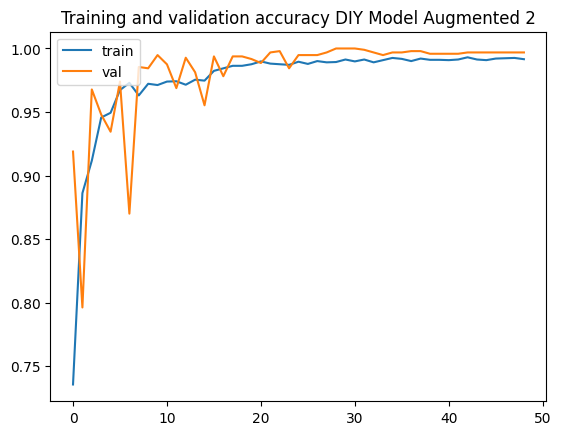

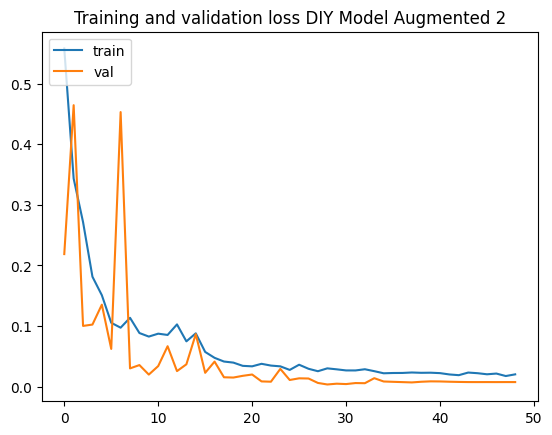

In [16]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_DIY_model_2.history['accuracy' ]
val_acc  = history_DIY_model_2.history['val_accuracy' ]
loss     = history_DIY_model_2.history['loss' ]
val_loss = history_DIY_model_2.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DIY Model Augmented 2')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DIY Model Augmented 2')
plt.legend(['train', 'val'], loc='upper left')